In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import joblib
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [7]:
def csv_files(all_csv_files): 
    """Locate csv"""
    for path, folder, file_list in os.walk(os.getcwd()):
            if len(file_list) > 0:
                for file in file_list:
                    if file[-4:]  == ".csv":
                        all_csv_files.append(os.path.join(path, file))

main_dir = os.getcwd()

# Locate csvs
all_csv_files = []            

# Hamza
os.chdir('/media/hamza/289875229874EFA4/WORK/annotation/done/sentiments')
csv_files(all_csv_files )

# uamir
os.chdir('/home/hamza/Documents/umair')
csv_files(all_csv_files )

# Farrukh
os.chdir('/home/hamza/Documents/farrukh')
csv_files(all_csv_files )

all_csv_files = list(set(all_csv_files))


# Merging all csvs
frames = [] 
for csv_file in all_csv_files:
    frames.append(pd.read_csv(csv_file))

df = pd.concat(frames)

print(df.size)
df.head()

66276


,Text,Sentiment
0,Maine samjha koi azda ya anaconda hoga. Yeh tu...,Neutral
1,"Ptyas Mucosa, commonly known as the Oriental R...",NaN
2,Shahab Uddin Yeah,NaN
3,Original dub then drop link,Neutral
4,From where can i watch it?,Neutral


In [8]:
mask = (df['Text'].str.len() <= 40)
df = df.loc[mask]

print(df.size)
df.head()

30112


,Text,Sentiment
2,Shahab Uddin Yeah,NaN
3,Original dub then drop link,Neutral
4,From where can i watch it?,Neutral
5,Didn't like it.,Negative
6,Farooq Sattar same here....,Neutral


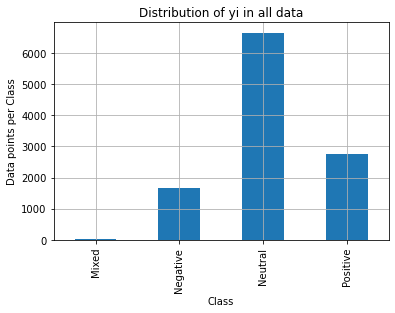

Number of data points in class 3 : 6642 ( 44.115 %)
Number of data points in class 4 : 2753 ( 18.285 %)
Number of data points in class 2 : 1669 ( 11.085 %)
Number of data points in class 1 : 45 ( 0.299 %)


In [9]:
def display_distribution(class_distribution, split_data_type, data_shape):
    my_colors = 'rgbkymc'
    class_distribution.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Data points per Class')
    plt.title(f'Distribution of yi in {split_data_type} data')
    plt.grid()
    plt.show()
    
    # ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
    # -(class_distribution.values): the minus sign will give us in decreasing order
    sorted_yi = np.argsort(-class_distribution.values)
    for i in sorted_yi:
        print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/data_shape*100), 3), '%)')

class_distribution = df['Sentiment'].value_counts().sort_index()
display_distribution(class_distribution=class_distribution, split_data_type="all", data_shape=df.shape[0])

In [10]:
print(df['Sentiment'].unique())
df.dropna(inplace=True)
df['Sentiment'].unique()
df.shape

[nan 'Neutral' 'Negative' 'Positive' 'Mixed']


(11109, 2)

In [11]:
# Change column "Score" values 
## 1-5(1/2 => negative, 3 => neutral, 4/5 => positive) to
## 0-1(negative/positive)

def partition(x):
    """
    Score>3 a positive rating,
    Score<3 a negative rating.
    """
    if x == 'Positive':
        return 0
    elif x == 'Negative':
        return 1
    elif x == 'Neutral':
        return 2
    elif x == 'Mixed':
        return 3

# changing reviews with score less than 3 to be positive and vice-versa
actualScore = df['Sentiment']
positiveNegative = actualScore.map(partition) 
df['Sentiment'] = positiveNegative

print("Number of data points in our data", df.shape)
df.head()

Number of data points in our data (11109, 2)


,Text,Sentiment
3,Original dub then drop link,2
4,From where can i watch it?,2
5,Didn't like it.,1
6,Farooq Sattar same here....,2
8,And jack is in it tooo,2


In [12]:
def decontracted(word):
    # https://www.kaggle.com/smat26/sentiment-analysis-on-roman-urdu
    import re
    import bs4 as bs
    # import re

    word = re.sub(r'ain$', r'ein', word)
    word = re.sub(r'ai', r'ae', word)
    word = re.sub(r'ay$', r'e', word)
    word = re.sub(r'ey$', r'e', word)
    word = re.sub(r'ie$', r'y', word)
    word = re.sub(r'^es', r'is', word)
    word = re.sub(r'a+', r'a', word)
    word = re.sub(r'j+', r'j', word)
    word = re.sub(r'd+', r'd', word)
    word = re.sub(r'u', r'o', word)
    word = re.sub(r'o+', r'o', word)
    word = re.sub(r'ee+', r'i', word)
    if not re.match(r'ar', word):
        word = re.sub(r'ar', r'r', word)
        word = re.sub(r'iy+', r'i', word)
        word = re.sub(r'ih+', r'eh', word)
        word = re.sub(r's+', r's', word)
    if re.search(r'[rst]y', 'word') and word[-1] != 'y':
        word = re.sub(r'y', r'i', word)
    if re.search(r'[bcdefghijklmnopqrtuvwxyz]i', word):
        word = re.sub(r'i$', r'y', word)
    if re.search(r'[acefghijlmnoqrstuvwxyz]h', word):
        word = re.sub(r'h', '', word)
        word = re.sub(r'k', r'q', word)
        
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', '', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.', '', word)
    word = re.sub(r'\\', ' ', word)
    word = re.sub(r'\\x\.+', '', word)
    word = re.sub(r'\d', '', word)
    word = re.sub(r'^_.', '', word)
    word = re.sub(r'_', ' ', word)
    word = re.sub(r'^ ', '', word)
    word = re.sub(r' $', '', word)
    word = re.sub(r'\?', '', word)
    
    # Remove HTML tags
    word = re.sub(r"http\S+", "", word)
    word = bs.BeautifulSoup(word, 'lxml').get_text()

    # Remove numeric values including alphanueric value
    word = re.sub("\S*\d\S*", "", word).strip()

    # Remove special chars
    word = re.sub('[^A-Za-z]+', ' ', word)
    return word.lower()
    
def lemmatizing(text):
    from nltk.stem import WordNetLemmatizer
    from nltk import word_tokenize

    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def text_preprocessing(df_text):
    from tqdm import tqdm
    
    preprocessed_msg = []
    # tqdm is for printing the status bar
    for sentance in tqdm(df_text.values):
        # Remove undesired chars
        sentance = decontracted(sentance)
        # sentance = lemmatizing(sentance)

        # Stop words
        ## https://deepnote.com/@umaimakhh/Sentimental-Analysis-on-Roman-Urdu-CYPLZfCxTjWGLxWzS2BaDg
        ## some words like Mein - Ma - Maa
        stopwords= ['uski', 'krna', 'kch', 'gai', 'raha', 'you', 'le', 'ki', 'krta', 'ga', 'jo', 'haan', 'de',
                    'hun', 'ho', 'meri', 'is', 'jee', 'lg', 'dain', 'hoa', 'jati', 'jana', 'rahi', 'kar', 'tou',
                    'photo', 'rha', 'ayi', 'wala', 'lye', 'kis', 'sy', 'ne', 'wohi', 'gy', 'gi', 'ny', 'hi', 'ab', 'gaya',
                    'je', 'hotay', 'jata', 'pe', 'hota', 'aye', 'me', 'tha', 'rahay', 'rhy', 'gya', 'us', 'thay', 'bhi',
                    'liye', 'sent', 'hai', 'aur', 'thi', 'jye', 'dono', 'phr', 'yehi', 'to', 'na', 'main', 'abi', 'hum',
                    'koi', 'hova', 'hain', 'ja', 'un', 'par', 'kafi', 'kr', 'hy', 'karna', 'h', 'krny', 'wo', 'kay', 'acha',
                    'mil', 'jb', 'ya', 'kya', 'ai', 'kuch', 'se', 'woh', 'thy', 'ap', 'houn', 'hay', 'sb', 'ka', 'he', 'han',
                    'chal', 'in', 'waisay', 'aese', 'hui', 'or', 'tu', 'ko', 'yeh']# , 'nai'

        
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)

        # Append processed sentense to list
        preprocessed_msg.append(sentance.strip())
        
    return preprocessed_msg
        
df['processed_text'] = text_preprocessing(df['Text'].astype("str"))
df.drop('Text', axis=1, inplace=True)
df.head()

100%|███████████████████████████████████| 11109/11109 [00:08<00:00, 1297.39it/s]


,Sentiment,processed_text
3,2,original dob ten drop linq
4,2,from were can i watc it
5,1,didn t like it
6,2,froq sattr same here
8,2,and jack it


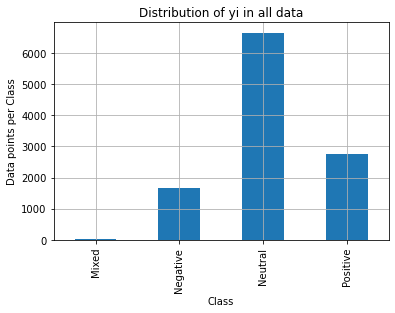

Number of data points in class 3 : 6642 ( 59.789 %)
Number of data points in class 4 : 2753 ( 24.782 %)
Number of data points in class 2 : 1669 ( 15.024 %)
Number of data points in class 1 : 45 ( 0.405 %)


In [13]:
display_distribution(class_distribution=class_distribution, split_data_type="all", data_shape=df.shape[0])

In [14]:
os.chdir("/home/hamza/Documents/sentiments")
joblib.dump(df, 'data/01_processed_data.joblib')

['data/01_processed_data.joblib']

In [37]:
df1 = df[df['Sentiment']==0][:317]
df2 = df[df['Sentiment']==1][:317]
df4 = df[df['Sentiment']==2][:317]

dff = pd.concat([df1, df2,df4])# df3, df4])

In [13]:
# joblib.dump(dff, 'data/03_downcasted_data.joblib')

In [9]:
df = joblib.load('/home/hamza/Documents/sentiments/data/01_processed_data.joblib')

In [10]:
## Upcasting
def augmentMyData(df, augmenter, label, repetitions=1, samples=200):
    from sklearn.utils import shuffle
    augmented_texts = []
    # select only the minority class samples
    spam_df = df[df['Sentiment'] == label].reset_index(drop=True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(spam_df), samples)):
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(spam_df['processed_text'].iloc[i])
            augmented_texts.append(augmented_text)
    
    data = {
        'Sentiment': label,
        'processed_text': augmented_texts
    }
    
    aug_df = pd.DataFrame(data)
    dff = shuffle(df.append(aug_df).reset_index(drop=True))
    return dff

import nlpaug.augmenter.word.context_word_embs as aug

augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
aug = augmentMyData(df, augmenter, samples=1000, label=0)
aug_df = augmentMyData(aug, augmenter, samples=1500, label=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

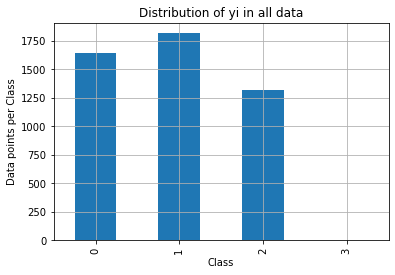

Number of data points in class 2 : 1817 ( 38.013 %)
Number of data points in class 1 : 1643 ( 34.372 %)
Number of data points in class 3 : 1318 ( 27.573 %)
Number of data points in class 4 : 2 ( 0.042 %)


In [11]:
class_distribution = aug_df['Sentiment'].value_counts().sort_index()
display_distribution(class_distribution=class_distribution, split_data_type="all", data_shape=aug_df.shape[0])

In [12]:
df1 = df[df['Sentiment']==0]
df2 = df[df['Sentiment']==1]
df4 = df[df['Sentiment']==2]

aug_df = pd.concat([df1, df2,df4])# df3, df4])

In [13]:
def split_data(dfff):
    Y = dfff['Sentiment'].values
    X = dfff['processed_text']
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    from sklearn.model_selection import train_test_split

    # Random sampling
    return train_test_split(X, Y, test_size=0.20) 

In [14]:
def tfidf(X_train, X_test):
    from sklearn.feature_extraction.text import TfidfVectorizer
    # from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

    vectorizer = TfidfVectorizer(max_features=1000)
    X_train = vectorizer.fit_transform(X_train)
    X_train = X_train.toarray()
    print(X_train.shape)

    X_test = vectorizer.transform(X_test)
    X_test = X_test.toarray()
    print(X_test.shape)
    
    return X_train, X_test

In [15]:
def BestMLAlgo(nlp_model, x_train, x_test, y_train, y_test):
    """Identify best Algo on given dataset"""
    from prettytable import PrettyTable
    
    table = PrettyTable()
    table.field_names = ["Vect", "Model", "Accuracy", "Precision", "Recall", "F1Score", "Log loss", "Roc Auc"]
                        
    import warnings
    warnings.filterwarnings("ignore")
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.linear_model import SGDClassifier
    from sklearn.calibration import CalibratedClassifierCV
    import xgboost
    from sklearn import svm
    from sklearn.metrics import precision_score, accuracy_score, roc_auc_score,\
                                roc_curve, auc, log_loss, recall_score
    
    base_models = {
        'kNN': KNeighborsClassifier(),
        'Naive Bayes': MultinomialNB(),
        'Log. Reg.': LogisticRegression(),
        'SVM Linear': SGDClassifier(class_weight='balanced', penalty='l2', loss='hinge', random_state=42),
        'SVM Non-linear': svm.SVC(kernel='rbf'),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boost': GradientBoostingClassifier(),
        'Ada Boost': AdaBoostClassifier(),
        'xgboost': xgboost.XGBClassifier(),
    }          
        
    for model_name, model in base_models.items():
        model.fit(x_train, y_train)
        model = CalibratedClassifierCV(model, method="sigmoid")
        model.fit(x_train, y_train)
        y_pred_proba = model.predict_proba(x_test)
        y_pred = model.predict(x_test)
            
        # Performance metrics
        accuracy        = round(accuracy_score(y_test, y_pred), 2)
        precision       = round(precision_score(y_test, y_pred, average='micro'), 2)
        recall          = round(recall_score(y_test, y_pred, average='micro'), 2)
        f1_score        = round((2*recall*precision)/(recall+precision), 2)
        loss            = round(log_loss(y_test, y_pred_proba, eps=1e-15), 2) # , labels=model.classes
        roc_auc         = round(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"), 2)        
        
        table.add_row([nlp_model, model_name, accuracy, precision, recall, f1_score, loss, roc_auc])
    print(table)

### With Weights data

In [23]:
X_train, X_test, y_train, y_test = split_data(df)
X_train, X_test = tfidf(X_train, X_test)


print(X_train.shape, " ", X_test.shape, " ", y_train.shape, " ",y_test.shape)

(1824, 1000)
(456, 1000)
(1824, 1000)   (456, 1000)   (1824,)   (456,)


In [22]:
BestMLAlgo("TFIDF", X_train, X_test, y_train, y_test)

ValueError: y_true and y_pred contain different number of classes 3, 4. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2]

### Downcasted data

In [38]:
X_train, X_test, y_train, y_test = split_data(dff)
X_train, X_test = tfidf(X_train, X_test)


print(X_train.shape, " ", X_test.shape, " ", y_train.shape, " ",y_test.shape)

(760, 1000)
(191, 1000)
(760, 1000)   (191, 1000)   (760,)   (191,)


In [39]:
BestMLAlgo("TFIDF", X_train, X_test, y_train, y_test)

[11:23:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

### Upcasting

In [16]:
X_train, X_test, y_train, y_test = split_data(aug_df)
X_train, X_test = tfidf(X_train, X_test)


print(X_train.shape, " ", X_test.shape, " ", y_train.shape, " ",y_test.shape)

(1822, 1000)
(456, 1000)
(1822, 1000)   (456, 1000)   (1822,)   (456,)


In [17]:
BestMLAlgo("TFIDF", X_train, X_test, y_train, y_test)

[12:18:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:19:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [18]:
df1 = df[df['Sentiment']==0][:1250]
df2 = df[df['Sentiment']==1][:1250]
df4 = df[df['Sentiment']==2][:1250]

aug_df_down = pd.concat([df1, df2,df4])# df3, df

In [19]:
X_train, X_test, y_train, y_test = split_data(aug_df_down)
X_train, X_test = tfidf(X_train, X_test)


print(X_train.shape, " ", X_test.shape, " ", y_train.shape, " ",y_test.shape)

(1768, 1000)
(442, 1000)
(1768, 1000)   (442, 1000)   (1768,)   (442,)


In [20]:
BestMLAlgo("TFIDF", X_train, X_test, y_train, y_test)

[12:21:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol